In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 13.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/DACON_23.07_PowerConsumption/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from lightgbm import early_stopping
import xgboost as xgb
import seaborn as sns

In [ ]:
def _smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    output = np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
    return output
smape = make_scorer(_smape, greater_is_better=False)

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
# building = pd.read_csv(f"{DATA_PATH}building_info.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [ ]:
train_ft = pd.read_csv(f"{DATA_PATH}train_feature8.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_feature8.csv")


# train_ft = pd.read_csv(f"{DATA_PATH}train_selected_3.csv")
# test_ft = pd.read_csv(f"{DATA_PATH}test_selected_3.csv")

# df = pd.read_csv(f"{DATA_PATH}train_featured_3.csv")


In [ ]:
# cols = ['day_hour_mean', 'day_hour_median', 'discomfort_CDH', 'week',
#        'day_hour_mode', 'discomfort', 'day_hour_std', 'CDH', 'hour_mean',
#        'sin_time', 'cos_week','building_num','energy_consum']

# train_ft = df[cols]

- 피처추가

In [ ]:
mask_train = train_ft['day_of_year'] != 152
train_ft = train_ft[mask_train]
train_ft.shape

(201600, 19)

In [ ]:

# Heat wave :
# 폭염 여부 추가

# train_ft['heat_wave'] = 0
# train_ft.loc[train_ft['temp'] >= 33, 'heat_wave'] = 1

# test_ft['heat_wave'] = 0
# test_ft.loc[test_ft['temp'] >= 33, 'heat_wave'] = 1



In [ ]:
20400-2040


18360

In [ ]:
train_ft.shape, test_ft.shape

((201600, 19), (16800, 18))

## 이동평균선, ewm

In [ ]:
date = pd.to_datetime(train['일시'])


In [ ]:

train['day_of_year'] = date.dt.dayofyear

# 6월 1일 삭제
mask = train['day_of_year'] != 152
train = train[mask]

tmp = train['일시']


In [ ]:
train.shape, train_ft.shape, tmp.shape #6월 1일 제거함

((201600, 11), (201600, 19), (201600,))

In [ ]:
tmp = tmp.reset_index().drop('index',axis=1)

In [ ]:
check_df = pd.concat([tmp,train_ft],axis=1)

check_df.shape

(201600, 20)

In [ ]:

check_df = check_df[['일시','energy_consum']]
check_df

,일시,energy_consum
0,20220602 00,1034.40
1,20220602 01,973.92
2,20220602 02,909.12
3,20220602 03,893.28
4,20220602 04,924.00
...,...,...
201595,20220824 19,881.04
201596,20220824 20,798.96
201597,20220824 21,825.12
201598,20220824 22,640.08


In [ ]:
840/24

35.0

In [ ]:
24*5

120

In [ ]:
24*7

168

In [ ]:
2040/24 # 85일치, -> 84일치 -> 7일치 지우면 77일치 (검증)

85.0

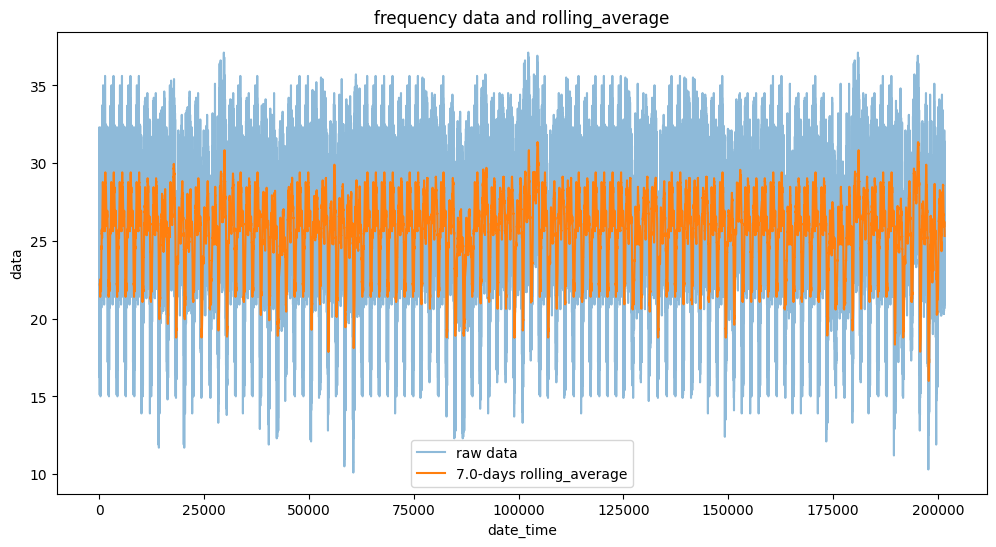

In [ ]:
# 5일치 (120) / 7일치 (168)
window_size = 168
rolling_average = train_ft['temp'].rolling(window=window_size).mean()


plt.figure(figsize=(12, 6))
plt.plot(check_df.index, train_ft['temp'], label='raw data', alpha=0.5)
plt.plot(rolling_average.index, rolling_average, label=f'{window_size / 24}-days rolling_average')
plt.legend()
plt.title('frequency data and rolling_average')
plt.xlabel('date_time')
plt.ylabel('data')
plt.show()

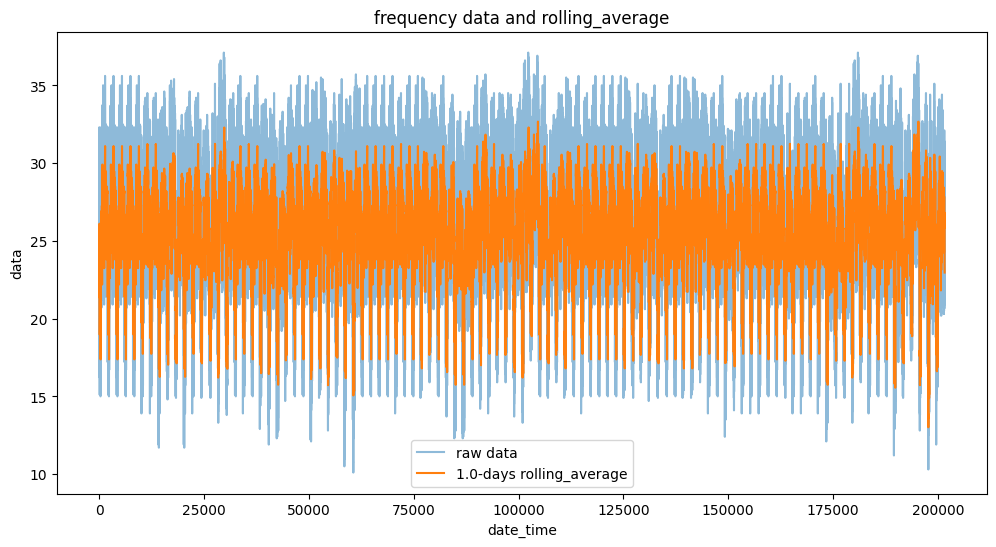

In [ ]:
# 5일치 (120) / 7일치 (168) / 하루치 (24) / 일별 평균?
window_size = 24
rolling_average = train_ft['temp'].rolling(window=window_size).mean()


plt.figure(figsize=(12, 6))
plt.plot(check_df.index, train_ft['temp'], label='raw data', alpha=0.5)
plt.plot(rolling_average.index, rolling_average, label=f'{window_size / 24}-days rolling_average')
plt.legend()
plt.title('frequency data and rolling_average')
plt.xlabel('date_time')
plt.ylabel('data')
plt.show()

In [ ]:
window_size = 24
rolling_average = train_ft['temp'].rolling(window=window_size).mean()

# 데이터프레임에 이동 평균 값을 추가합니다.
train_ft['rolling_average'] = rolling_average

# 출력을 통해 데이터프레임을 확인합니다.
mask = train_ft['rolling_average'].isna() == True
train_ft[mask]

,energy_consum,building_num,temp,precip,wind,hum,day,month,week,day_of_year,sin_time,cos_time,THI,feels_temp,CDH,hour_mean,heat_index,day_hour_mean,hour_std,rolling_average
0,1034.40,1,18.1,0.0,0.4,67.0,3,6,22,153,0.000000e+00,1.000000e+00,63.38573,22.524968,-22.2,1713.711429,0.0,1627.80,444.306331,NaN
1,973.92,1,17.6,0.0,0.8,69.0,3,6,22,153,2.588190e-01,9.659258e-01,62.71156,21.949295,-32.9,1629.468571,0.0,1550.08,437.718795,NaN
2,909.12,1,17.2,0.0,0.7,71.0,3,6,22,153,5.000000e-01,8.660254e-01,62.16888,21.493024,-44.1,1513.305714,0.0,1431.12,410.362488,NaN
3,893.28,1,17.2,0.0,2.2,75.0,3,6,22,153,7.071068e-01,7.071068e-01,62.27800,21.561793,-55.2,1443.122857,0.0,1372.20,389.916262,NaN
4,924.00,1,17.2,0.0,2.0,81.0,3,6,22,153,8.660254e-01,5.000000e-01,62.44168,21.653550,-65.6,1452.808571,0.0,1381.72,379.995696,NaN
5,1074.24,1,17.6,0.0,2.7,80.0,3,6,22,153,9.659258e-01,2.588190e-01,63.05520,22.136150,-75.1,1585.905714,0.0,1526.84,393.582746,NaN
6,1390.08,1,17.8,0.0,2.4,80.0,3,6,22,153,1.000000e+00,6.123234e-17,63.37560,22.384609,-83.6,1847.397143,0.0,1866.40,401.657375,NaN
7,1739.04,1,18.4,0.0,2.6,77.0,3,6,22,153,9.659258e-01,-2.588190e-01,64.21932,23.081658,-89.5,2214.705714,0.0,2363.96,457.177800,NaN
8,2380.80,1,19.0,0.0,2.4,71.0,3,6,22,153,8.660254e-01,-5.000000e-01,64.89210,23.715092,-92.7,2667.514286,0.0,2829.04,455.523997,NaN
9,2664.96,1,21.0,0.0,2.2,66.0,3,6,22,153,7.071068e-01,-7.071068e-01,67.59340,26.066180,-92.4,3101.711429,0.0,3228.64,485.613075,NaN


In [ ]:
train_ft.columns

Index(['energy_consum', 'building_num', 'temp', 'precip', 'wind', 'hum', 'day',
       'month', 'week', 'day_of_year', 'sin_time', 'cos_time', 'THI',
       'feels_temp', 'CDH', 'hour_mean', 'heat_index', 'day_hour_mean',
       'hour_std'],
      dtype='object')

In [ ]:
train_ft.shape, test_ft.shape

((201600, 19), (16800, 18))

- 건물별 ft 생성

In [ ]:
for i in range(1, 101):
    globals()[f'train_ft_{i}'] = train_ft[train_ft['building_num'] == i]

for i in range(1, 101):
    globals()[f'test_ft_{i}'] = test_ft[test_ft['building_num'] == i]

## 공휴일 반영